In [ ]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words.add("roll")

sns.set_theme()

In [8]:
def wordcloud(text):
  wordcloud = WordCloud(background_color="white").generate(text)
  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")

In [9]:
# Abertura dos arquivos
podcast_file = open('data/general_podcasts.csv', mode='r')
skills_file = open('data/skills_dataset.csv', mode='r')
CR_file = open('data/CR_skills_dataset.csv', mode='r')

# Podcast

In [10]:
# Transforma os dados do csv em um dataframe
podcast_df = pd.read_csv(podcast_file)

In [11]:
# Substitui espaços em branco por NaN
podcast_df = podcast_df.replace(r'^\s*$', np.NaN, regex=True)
# Vertifica número de linhas nulas para cada coluna do arquivo
podcast_df.isnull().sum()

skill            0
backward_text    0
check_line       0
original_name    0
dtype: int64

In [12]:
# Aplica uma função que limpa espaços em branco antes e depois da skill, além de passar para letra minúscula
podcast_df["skill"] = podcast_df["skill"].apply(lambda x: x.strip().lower())

# Agrupa e conta o número frases por skill, também coloca as skills em ordem alfabética 
podcast_pps = podcast_df.groupby(by="skill", sort=True).count()['backward_text']
podcast_pps

skill
acrobatics          82
animal handling     47
arcana             103
athletics          137
concentration        1
deception          105
disguise             3
history             42
insight             87
intimidation        42
investigation      204
medicine            41
nature              49
perception         405
performance         77
persuasion          63
religion            15
sleight of hand     41
stealth            125
survival            64
Name: backward_text, dtype: int64

In [13]:
podcast_pps["persuasion"]

63

# Skills

In [14]:
# Transforma os dados do csv em um dataframe
skills_df = pd.read_csv(skills_file)

In [15]:
# Substitui os campos com espaço em branco por NaN
skills_df = skills_df.replace(r'^\s*$', np.NaN, regex=True)
# Vertifica número de linhas nulas para cada coluna do arquivo
skills_df.isnull().sum()

skill             54
backward_text      0
original_name    155
dtype: int64

In [16]:
# Lista linhas que estão com NaN no campo skill
skills_df.loc[skills_df["skill"].isnull()]

,skill,backward_text,original_name
7692,NaN,>The remaining trio of Goblins immediately lau...,#4
7693,NaN,>The remaining trio of Goblins immediately lau...,#5
7694,NaN,>The remaining trio of Goblins immediately lau...,#6
9958,NaN,>Sticks bound off scale and fists find only ai...,12)
9961,NaN,>Sticks bound off scale and fists find only ai...,12)
9964,NaN,>Sticks bound off scale and fists find only ai...,10)
9967,NaN,>Sticks bound off scale and fists find only ai...,10)
10064,NaN,> Medicus #2,(13)
10080,NaN,>Vigilance,10
10117,NaN,>Vigilant,10-1=9


In [17]:
# Remove todas as linhas com NaN no campo skill
skill_df = skills_df.dropna(subset=["skill"], inplace=True)
# Soma as linhas com NaN no campo skill
skills_df["skill"].isnull().sum()

0

In [18]:
# Aplica uma função que transforma o campo em string,
# limpa espaços em branco antes e depois da string, além de passar para letra minúscula
skills_df["skill"] = skills_df["skill"].apply(lambda x: str(x).strip().lower())
skills_df

,skill,backward_text,original_name
0,history,"> nodded accepting the parcel by ’s hands, in ...",Lore
1,performance,"> nodded accepting the parcel by ’s hands, in ...",Song
2,arcana,">""Aye, give me but a moment to study this piec...",Craft
3,medicine,>(Healing roll: to see if he can remember anyt...,Healing
4,survival,>(OOC: Travel roll. Do we need even to test co...,Travel
...,...,...,...
49800,survival,"The great beast leaps through the camp, pierc...",Hunting
49801,perception,As the darkness surrounds and your feeble fir...,Awareness
49802,stealth,[OOC: For anyone new to TOR or unfamiliar wit...,Stealth
49803,perception,[OOC: For anyone new to TOR or unfamiliar wit...,Awareness


In [19]:
# Agrupa e conta o número frases por skill, além de colocar em ordem alfabética de skill.
skills_pps = skills_df.groupby(by="skill", sort=True).count()["backward_text"]
skills_pps

skill
#1 atk                  14
#2                       1
#2 atk                  15
#3 atk                  11
#4 atk                   4
                        ..
​hit 61                  3
​insight check           1
​opportunity attack      1
​str                     1
​willpower hard  @30     1
Name: backward_text, Length: 9307, dtype: int64

In [20]:
skills_pps["persuasion"]

540

# CR skills

In [21]:
# Transforma os dados do csv em um dataframe
CR_df = pd.read_csv(CR_file)

In [22]:
# Substitui campos com espaço em branco por NaN
CR_df = CR_df.replace(r'^\s*$', np.NaN, regex=True)
# Vertifica número de linhas nulas para cada coluna do arquivo
CR_df.isnull().sum()

skill            0
backward_text    0
check_line       0
dtype: int64

In [23]:
# Aplica uma função que limpa espaços em branco antes e depois da skill, além de passar para letra minúscula
CR_df['skill'] = CR_df['skill'].apply(lambda x: x.strip().lower())
CR_df

,skill,backward_text,check_line
0,persuasion,‘Cause the dwarves weren't fans of nobody with...,and rolled pretty damn well on a persuasion ch...
1,persuasion,Careful. (sighs) Not as often as I get woken u...,Matt: Make a persuasion roll.
2,persuasion,You're so… we just heard you're so… impressive...,Matt: (To Marisha) Make a persuasion check.
3,persuasion,"they're terrible people. Anyway, my associates...",Matt: Make a persuasion roll. You can assist i...
4,persuasion,"Anyway, my associates and I were wondering if ...",Taliesin: I'm assisting in this persuasion rol...
...,...,...,...
5249,investigation,(laughter) (sings) Continuity. Roll for contin...,investigation check.
5250,insight,"wall. There is a very, very faint scratch into...",TRAVIS: Insight check.
5251,deception,advice from when it comes to administrating my...,MATT: Make a deception check.
5252,stealth,I was under the assumption that you had to be ...,MATT: Okay. Go ahead and make a stealth check.


In [134]:
# Agrupa e conta o número frases por skill, também coloca as skills em ordem alfabética 
# PPS = phrases per skill
CR_pps = CR_df.loc[: , ["skill"]]
CR_pps['frequency'] = CR_pps.groupby('skill')['skill'].transform('count')
CR_pps =  CR_pps.drop_duplicates()
# CR_df.groupby(by="skill", sort=True).count()
# CR_pps = Counter(CR_df["skill"])
CR_pps

,skill,frequency
0,persuasion,333
6,perception,1431
7,insight,445
10,intimidation,111
12,stealth,609
13,acrobatics,236
15,performance,44
21,sleight of hand,57
26,athletics,371
58,nature,183


In [25]:
CR_pps["persuasion"]

333

# Tabela total

In [26]:
# Dataframe resultado da concatenação dos três dataframes
concatenated_df = pd.concat([podcast_df,skills_df,CR_df])

In [27]:
# Agrupa e conta o número frases por skill, também coloca as skills em ordem alfabética 
total_pps = concatenated_df.groupby("skill", sort=True).count()['backward_text']
total_pps

skill
#1 atk                  14
#2                       1
#2 atk                  15
#3 atk                  11
#4 atk                   4
                        ..
​hit 61                  3
​insight check           1
​opportunity attack      1
​str                     1
​willpower hard  @30     1
Name: backward_text, Length: 9307, dtype: int64

In [28]:
total_pps["persuasion"]

936

In [29]:
"""
    Função que transforma uma lista de palavras bem formatadas em um dicionário de ocorrências.
    Ex.:
        > x = ['Philipe', 'Jc', 'Victor', 'Philipe', 'Jc', 'Victor', 'Victor', 'Jc']
        > ocorrencias(x)
        > {'Philipe': 2, 'Jc': 3, 'Victor': 3}
"""
def ocorrencias(lista):
    dict_ocorrencias = {}
    for i in lista:
        if i in dict_ocorrencias:
            dict_ocorrencias[i] += 1
        else:
            dict_ocorrencias[i] = 1
    return dict_ocorrencias

In [160]:
"""
    Função que dado um dicionário de ocorrências ou lista bem formatada,
    plota um gráfico com as palavras com maior ocorrência (15 por padrão).
"""
def bar_graphic(dicionario=None, paleta="rocket", lista_ocorrencias = None, max=15, dim=(12,9), title=None):
    # Se não tiver dicionario, vai ter uma lista
    if dicionario is None:
        if lista_ocorrencias is not None:
            # A lista é então convertida para dicionario através da função de ocorrencias
            dicionario = ocorrencias(lista_ocorrencias)
    
    # O dicionario é transformado em dataframe para melhor manipulação
    df = pd.DataFrame(dicionario.items(), columns=["key", "value"])
    # Dataframe ordenado de forma decrescente e com o máximo estipulado
    df = df.sort_values(by="value", ascending=False).head(max)
    
    # É então re-convertido em dicionario
    top_dicionario = dict(df.values)
    
    # As chaves e valores são convertidas em lista para auxiliar na plotagem do gráfico
    palavras = list(top_dicionario.keys())
    valores = list(top_dicionario.values())
    
    ## Plot
    # Define dimensões para o gráfico
    fig_dims = dim
    fig, ax = plt.subplots(figsize=fig_dims)
    # Configura o eixo, paleta e dimensões do gráfico
    plot = sns.barplot(x=palavras,y=valores, palette=paleta, ax=ax)
    # Define o título do gráfico
    if title is None:
        plt.title(f'Top {max} Ocorrências')
    else:
        plt.title(title)
    # Rotaciona a legenda de cada barra e plota o gráfico
    plt.setp(plot.get_xticklabels(), rotation=45)

In [31]:
total_pps_dict = total_pps.to_dict()
total_pps_dict

{'#1 atk': 14,
 '#2': 1,
 '#2 atk': 15,
 '#3 atk': 11,
 '#4 atk': 4,
 '-damage': 1,
 '1': 1,
 '1 dmg': 1,
 '1 to 4 silver darter 5 rabbit viper 6 the bad snake': 1,
 '15-12=16': 1,
 '16-12=17': 1,
 '1d20': 1,
 '1d6': 1,
 '1d61': 1,
 '2': 1,
 '2 dmg': 1,
 '3': 1,
 '3 dmg': 1,
 '3rd try': 1,
 '4': 1,
 '5 = volkbert': 1,
 '@26': 1,
 '_2nd_crit': 1,
 '_crit': 1,
 '_dodge': 1,
 '_extradamage': 1,
 '_parry': 1,
 'a': 3,
 'a  heavin   amp  a hoin': 1,
 'a  o    elixir of life': 1,
 'a  o    life elixir': 1,
 'a att': 3,
 'a bitter memory': 1,
 'a blip on my scope': 1,
 'a bold display': 1,
 'a d   to add modifiers to for whatever is needed here': 1,
 'a dam': 3,
 'a die': 14,
 'a die   wits': 1,
 'a die  wits and bonus': 1,
 'a disadvantage': 1,
 'a feinting guard': 1,
 'a good spine throttling': 1,
 'a init': 1,
 'a little extra whip tlc for': 1,
 'a mysterious die of fate': 1,
 'a or d damage': 1,
 'a paladin prepares initiative': 1,
 'a roll': 1,
 'a s': 4,
 'a savin  the boat driver': 1,


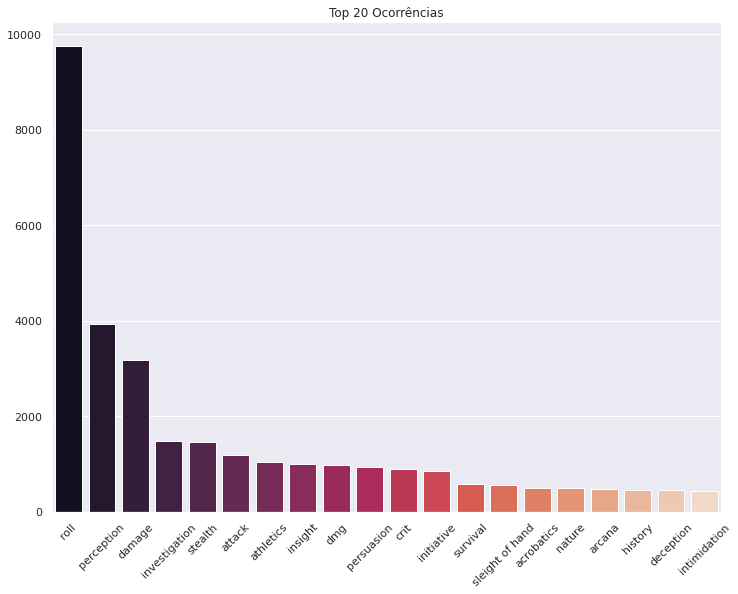

In [32]:
# Total set
bar_graphic(dicionario = total_pps_dict, max=20)

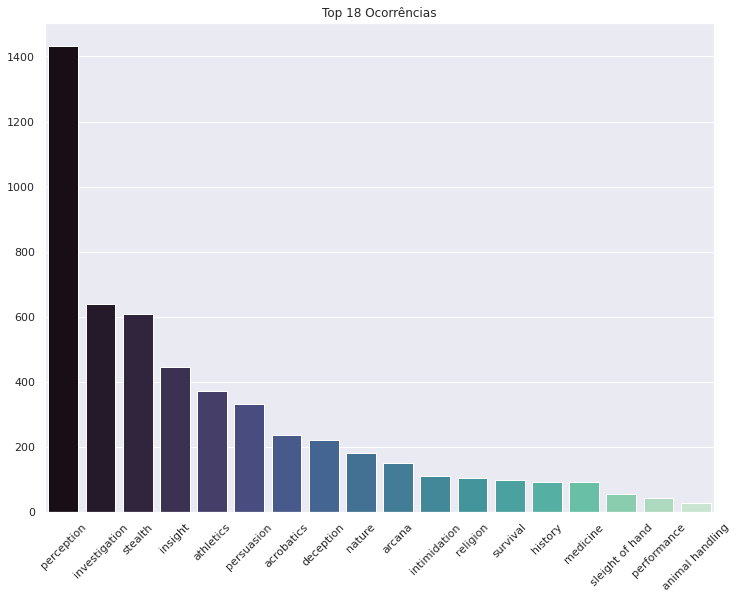

In [33]:
# CR Set
CR_pps_dict = CR_pps.to_dict()
bar_graphic(dicionario=CR_pps_dict, paleta="mako", max=18)

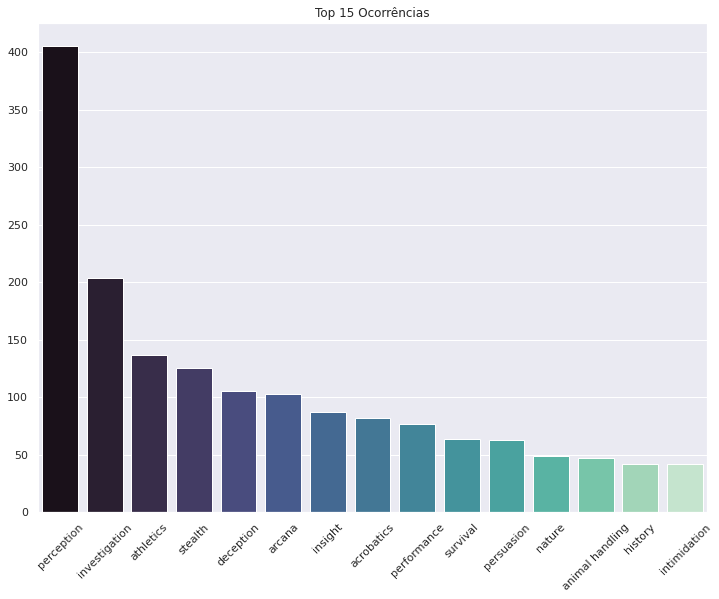

In [34]:
# Podcast set
podcast_pps_dict = podcast_pps.to_dict()
bar_graphic(dicionario = podcast_pps_dict, paleta="mako")

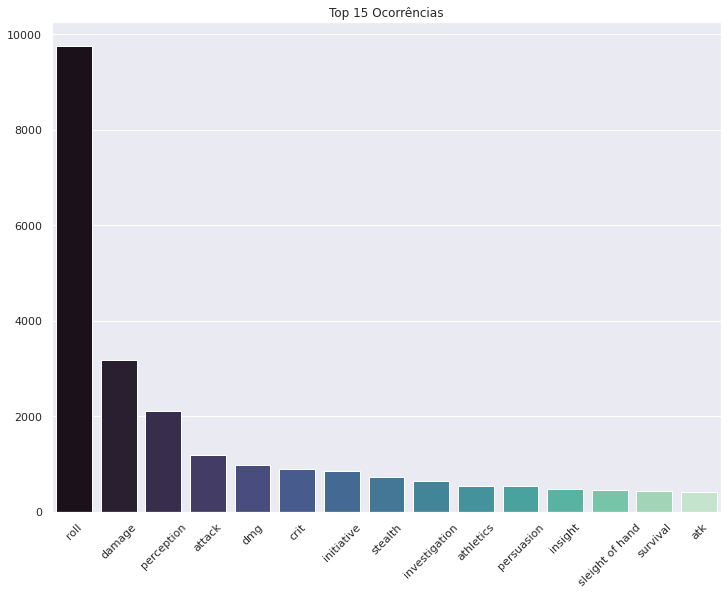

In [35]:
# Skills Set
skills_pps_dict = skills_pps.to_dict()
bar_graphic(dicionario = skills_pps_dict, paleta="mako")

# Total de Palavras do backward_text

In [36]:
# Transforma cada linha da coluna de frases do dataframe em lista cujos elementos 
# são as frases
list_df = list(concatenated_df["backward_text"])
# Separa a lista de frases em uma lista de lista de palavras
full_list = [i.split(" ") for i in list_df]
full_list

[['going',
  'weekly',
  'for',
  'the',
  'rest',
  'of',
  'the',
  'experimental',
  'arcs',
  '[',
  'Woohoo!]',
  'starting',
  'this',
  'week.',
  'So,',
  'um,',
  'I',
  'guess',
  'actually',
  'we',
  'have',
  'an',
  'episode—',
  'I',
  'hope',
  'we',
  'don’t',
  'screw',
  'it',
  'up!'],
 ['by,',
  'like,',
  'logic,',
  'you',
  'know',
  'what',
  'I',
  'mean?',
  'So',
  'I',
  'can’t',
  'be',
  'like,',
  '“I',
  'wanna',
  'Help',
  'Out',
  'by…”',
  '[inhaling',
  'sharply',
  'through',
  'teeth]',
  'Ssssssssssssss...',
  'Ooooh,',
  'logic.',
  '“...pulling',
  'the',
  'sun',
  'down.”',
  'Yeah.'],
 ['success,',
  'you',
  'open',
  'yourself',
  'up',
  'to',
  'repercussions.',
  'To,',
  'like,',
  'the',
  'same',
  'reper—',
  'so',
  'you',
  'can',
  'help',
  'out,',
  'yeah,',
  'but',
  'you',
  'are',
  'also',
  'exposing',
  'yourself',
  'to',
  'danger,',
  'which',
  'is',
  'real',
  'smart.'],
 ['success,',
  'you',
  'open',
  'yoursel

In [37]:
# Transforma uma lista de 2 dimensões em 1
flat_list = [item for sublist in full_list for item in sublist]
flat_list

['going',
 'weekly',
 'for',
 'the',
 'rest',
 'of',
 'the',
 'experimental',
 'arcs',
 '[',
 'Woohoo!]',
 'starting',
 'this',
 'week.',
 'So,',
 'um,',
 'I',
 'guess',
 'actually',
 'we',
 'have',
 'an',
 'episode—',
 'I',
 'hope',
 'we',
 'don’t',
 'screw',
 'it',
 'up!',
 'by,',
 'like,',
 'logic,',
 'you',
 'know',
 'what',
 'I',
 'mean?',
 'So',
 'I',
 'can’t',
 'be',
 'like,',
 '“I',
 'wanna',
 'Help',
 'Out',
 'by…”',
 '[inhaling',
 'sharply',
 'through',
 'teeth]',
 'Ssssssssssssss...',
 'Ooooh,',
 'logic.',
 '“...pulling',
 'the',
 'sun',
 'down.”',
 'Yeah.',
 'success,',
 'you',
 'open',
 'yourself',
 'up',
 'to',
 'repercussions.',
 'To,',
 'like,',
 'the',
 'same',
 'reper—',
 'so',
 'you',
 'can',
 'help',
 'out,',
 'yeah,',
 'but',
 'you',
 'are',
 'also',
 'exposing',
 'yourself',
 'to',
 'danger,',
 'which',
 'is',
 'real',
 'smart.',
 'success,',
 'you',
 'open',
 'yourself',
 'up',
 'to',
 'repercussions.',
 'To,',
 'like,',
 'the',
 'same',
 'reper—',
 'so',
 'you',

In [38]:
# Transforma tudo que não sejam números ou letras em string vazia, passa para letra minúscula
filtered_flat_list = [re.sub('[^A-Za-z0-9]+', '', i).lower() for i in flat_list]
# Remove as strings vazias da lista
filtered_flat_list = [x for x in filtered_flat_list if x]
filtered_flat_list

['going',
 'weekly',
 'for',
 'the',
 'rest',
 'of',
 'the',
 'experimental',
 'arcs',
 'woohoo',
 'starting',
 'this',
 'week',
 'so',
 'um',
 'i',
 'guess',
 'actually',
 'we',
 'have',
 'an',
 'episode',
 'i',
 'hope',
 'we',
 'dont',
 'screw',
 'it',
 'up',
 'by',
 'like',
 'logic',
 'you',
 'know',
 'what',
 'i',
 'mean',
 'so',
 'i',
 'cant',
 'be',
 'like',
 'i',
 'wanna',
 'help',
 'out',
 'by',
 'inhaling',
 'sharply',
 'through',
 'teeth',
 'ssssssssssssss',
 'ooooh',
 'logic',
 'pulling',
 'the',
 'sun',
 'down',
 'yeah',
 'success',
 'you',
 'open',
 'yourself',
 'up',
 'to',
 'repercussions',
 'to',
 'like',
 'the',
 'same',
 'reper',
 'so',
 'you',
 'can',
 'help',
 'out',
 'yeah',
 'but',
 'you',
 'are',
 'also',
 'exposing',
 'yourself',
 'to',
 'danger',
 'which',
 'is',
 'real',
 'smart',
 'success',
 'you',
 'open',
 'yourself',
 'up',
 'to',
 'repercussions',
 'to',
 'like',
 'the',
 'same',
 'reper',
 'so',
 'you',
 'can',
 'help',
 'out',
 'yeah',
 'but',
 'you',


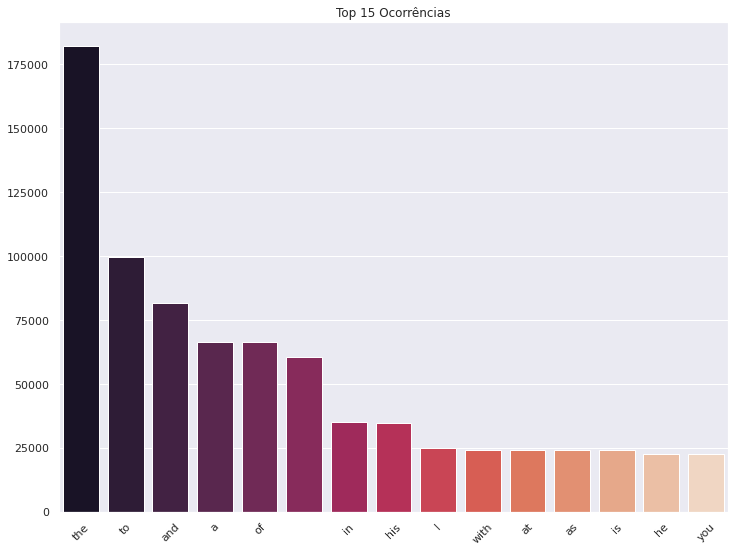

In [39]:
bar_graphic(lista_ocorrencias = flat_list)

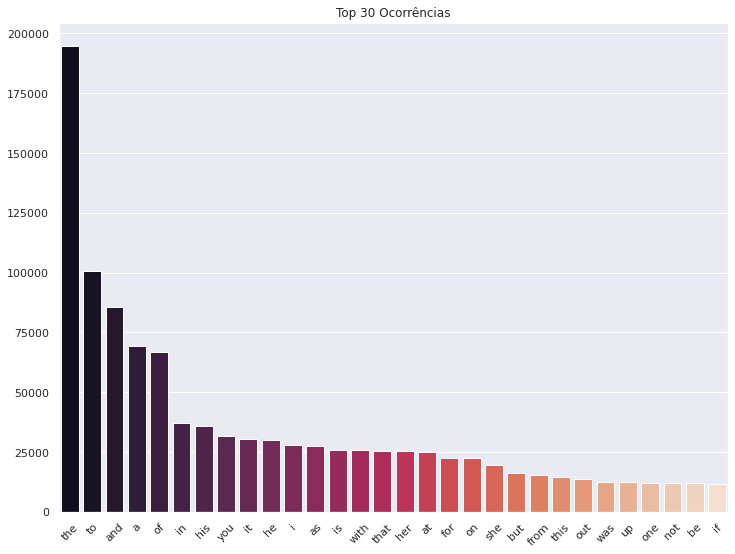

In [40]:
bar_graphic(lista_ocorrencias = filtered_flat_list, max=30)

In [41]:
list_slice = list_df[0:11]
list_slice

['going weekly for the rest of the experimental arcs [ Woohoo!] starting this week. So, um, I guess actually we have an episode— I hope we don’t screw it up!',
 'by, like, logic, you know what I mean? So I can’t be like, “I wanna Help Out by…” [inhaling sharply through teeth] Ssssssssssssss... Ooooh, logic. “...pulling the sun down.” Yeah.',
 'success, you open yourself up to repercussions. To, like, the same reper— so you can help out, yeah, but you are also exposing yourself to danger, which is real smart.',
 'success, you open yourself up to repercussions. To, like, the same reper— so you can help out, yeah, but you are also exposing yourself to danger, which is real smart.',
 'play in the NFL!” and he was like “No.” There’s some really- we haven’t— I really like this idea of a Chosen that’s just like [crosstalk] “No, no thank you!”',
 'you are dealing with the consequences of your own spellcasting. That’s definitely this. Um. Yeah so- but if it’s Weird, I rolled an eight plus two s

In [43]:
doc = nlp(list_slice[0])
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

going go VERB VBG ROOT xxxx True False
weekly weekly ADV RB advmod xxxx True False
for for ADP IN prep xxx True True
the the DET DT det xxx True True
rest rest NOUN NN pobj xxxx True False
of of ADP IN prep xx True True
the the DET DT det xxx True True
experimental experimental ADJ JJ amod xxxx True False
arcs arc NOUN NNS pobj xxxx True False
[ [ PUNCT -LRB- punct [ False False
Woohoo Woohoo PROPN NNP npadvmod Xxxxx True False
! ! PUNCT . punct ! False False
] ] PUNCT -RRB- punct ] False False
starting start VERB VBG advcl xxxx True False
this this DET DT det xxxx True True
week week NOUN NN npadvmod xxxx True False
. . PUNCT . punct . False False
So so ADV RB advmod Xx True True
, , PUNCT , punct , False False
um um INTJ UH intj xx True False
, , PUNCT , punct , False False
I I PRON PRP nsubj X True True
guess guess VERB VBP ROOT xxxx True False
actually actually ADV RB advmod xxxx True False
we we PRON PRP nsubj xx True True
have have VERB VBP ccomp xxxx True True
an an DET DT det x

In [44]:
for token in doc:
    if not token.is_stop and token.pos_ in ("VERB", "NOUN"):
        print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
                token.shape_, token.is_alpha, token.is_stop)

going go VERB VBG ROOT xxxx True False
rest rest NOUN NN pobj xxxx True False
arcs arc NOUN NNS pobj xxxx True False
starting start VERB VBG advcl xxxx True False
week week NOUN NN npadvmod xxxx True False
guess guess VERB VBP ROOT xxxx True False
episode episode NOUN NN dobj xxxx True False
hope hope VERB VBP ccomp xxxx True False
screw screw VERB VB ccomp xxxx True False


In [45]:
len(list_df)

56738

In [42]:
result_list = []
for i in list_df:
    doc = nlp(i)
    result_list_element = []
    for token in doc:
        if not token.is_stop and token.pos_ in ("VERB", "NOUN"):
            result_list_element.append(token.text)
    result_list.append(result_list_element)

In [46]:
result_list[0]

['going',
 'rest',
 'arcs',
 'starting',
 'week',
 'guess',
 'episode',
 'hope',
 'screw']

In [47]:
bar_graphic(lista_ocorrencias = result_list, max=30)

TypeError: unhashable type: 'list'

In [144]:
skill_list = list(CR_df['skill'].unique())

In [136]:
skill_text_df = concatenated_df.loc[:,["skill", "backward_text"]]
skill_text_df

,skill,backward_text
0,perception,going weekly for the rest of the experimental ...
1,performance,"by, like, logic, you know what I mean? So I ca..."
2,investigation,"success, you open yourself up to repercussions..."
3,insight,"success, you open yourself up to repercussions..."
4,perception,play in the NFL!” and he was like “No.” There’...
...,...,...
5249,investigation,(laughter) (sings) Continuity. Roll for contin...
5250,insight,"wall. There is a very, very faint scratch into..."
5251,deception,advice from when it comes to administrating my...
5252,stealth,I was under the assumption that you had to be ...


In [138]:
def filter_irrelevant_words(phrase):
    doc = nlp(phrase)
    word_list = []
    for token in doc:
        if not token.is_stop and token.pos_ in ("VERB", "NOUN"):
            word_list.append(token.text)
    return word_list

In [183]:
skill_text_df["filtered_words"] = skill_text_df["backward_text"].apply(filter_irrelevant_words)


[2021-06-28 19:46:00,534] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'going'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,534] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'weekly'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,536] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'for'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,536] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,53

[2021-06-28 19:46:00,555] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'screw'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,556] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'it'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,558] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'up'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,558] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '!'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,563] [WAR

[2021-06-28 19:46:00,577] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'through'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,577] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'teeth'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,578] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ']'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,578] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Ssssssssssssss'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 1

[2021-06-28 19:46:00,598] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'reper'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,598] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '—'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,599] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'so'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,599] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,600] [WA

[2021-06-28 19:46:00,621] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,621] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'like'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,622] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,622] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,622] [WARN

[2021-06-28 19:46:00,646] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '”'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,646] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'and'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,647] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'he'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,647] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'was'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,647] [WARN

[2021-06-28 19:46:00,661] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,662] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'no'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,662] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'thank'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,662] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,663] [WA

[2021-06-28 19:46:00,686] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'an'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,687] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'eight'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,687] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'plus'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,688] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'two'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,688] 

[2021-06-28 19:46:00,712] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ''s'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,713] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'true'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,714] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,714] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'yeah'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,715] [WA

[2021-06-28 19:46:00,732] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'n't'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,732] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,733] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'see'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,734] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '?'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,735] [WAR

[2021-06-28 19:46:00,758] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'leaning'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,758] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'backwards'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,758] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,759] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'shooting'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:

[2021-06-28 19:46:00,779] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'it'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,779] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '’s'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,780] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'information'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,780] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'we'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,78

[2021-06-28 19:46:00,798] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'You'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,799] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'did'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,799] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'a'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,799] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bad'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,800] [WAR

[2021-06-28 19:46:00,818] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Hide'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,819] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Under'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,820] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Pressure'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,820] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '?'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,8

[2021-06-28 19:46:00,841] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'cool'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,841] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'line'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,842] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,843] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Yeah'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,844] [

[2021-06-28 19:46:00,867] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'clothes'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,867] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '—'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,868] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Oh'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,868] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '!'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,869] [WA

[2021-06-28 19:46:00,888] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,888] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'and'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,889] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'your'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,889] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'companions'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00

[2021-06-28 19:46:00,913] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'rage'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,913] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,914] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'No'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,915] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,915] [WARNI

[2021-06-28 19:46:00,932] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Adventuring'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,932] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,932] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'essentially'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,933] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:4

[2021-06-28 19:46:00,957] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'your'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,958] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'boss'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,958] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,958] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'but'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,959] [W

[2021-06-28 19:46:00,983] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,983] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'and'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,983] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'things'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00,983] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'definitely'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:00

[2021-06-28 19:46:01,003] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '6'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,004] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,005] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'And'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,005] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'what'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,008] [WARN

[2021-06-28 19:46:01,033] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'to'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,034] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'a'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,035] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'stop'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,035] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,035] [WARNI

[2021-06-28 19:46:01,049] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'wagon'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,050] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,059] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'is'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,060] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'where'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,060] [

[2021-06-28 19:46:01,074] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'You'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,075] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'do'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,075] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'not'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,076] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,076] [WARN

[2021-06-28 19:46:01,095] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'discretion'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,097] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'what'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,097] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'does'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,098] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'and'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:0

[2021-06-28 19:46:01,124] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '?'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,125] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '…'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,126] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Um'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,127] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '…'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,128] [WARNING]

[2021-06-28 19:46:01,150] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'next'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,150] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'to'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,152] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,153] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'wagon'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,153] 

[2021-06-28 19:46:01,173] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'ca'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,175] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'n’t'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,175] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'exactly'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,176] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'see-'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,177

[2021-06-28 19:46:01,200] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,201] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,201] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'ca'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,202] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'n’t'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,202] [WARN

[2021-06-28 19:46:01,224] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,224] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'woods'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,225] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,225] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,225] [W

[2021-06-28 19:46:01,244] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'it'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,244] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'into'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,244] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,245] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'woods'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,245] 

[2021-06-28 19:46:01,268] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,269] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'A'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,269] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'wave'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,270] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'of'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,271] [WARNI

[2021-06-28 19:46:01,286] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'They'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,286] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'definitely'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,287] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'do'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,287] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,28

[2021-06-28 19:46:01,308] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'in'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,308] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,308] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'room'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,309] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'other'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,309] 

[2021-06-28 19:46:01,328] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Excellent'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,328] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,328] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'well'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,329] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,329]

[2021-06-28 19:46:01,345] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'do'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,345] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,346] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'need'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,346] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'to'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,347] [WARN

[2021-06-28 19:46:01,368] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'gerblin'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,369] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,370] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'uh'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,370] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,371] [WA

[2021-06-28 19:46:01,391] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'like'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,391] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'it'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,392] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '’ll'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,392] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hold'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,392] [

[2021-06-28 19:46:01,408] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '['. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,408] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'dice'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,409] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'roll'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,409] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ']'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,415] [WAR

[2021-06-28 19:46:01,429] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '?'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,430] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '['. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,430] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'laughter'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,431] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ']'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,431] [WA

[2021-06-28 19:46:01,451] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'we'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,451] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ''re'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,451] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'trying'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,452] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'to'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,452] [

[2021-06-28 19:46:01,474] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Taako'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,474] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ']'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,476] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Well'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,476] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'yeah'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,477] 

[2021-06-28 19:46:01,496] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'better'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,497] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'by'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,497] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'myself'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,497] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,498]

[2021-06-28 19:46:01,520] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'n't'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,521] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'know'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,522] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'is'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,522] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'there'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,523] 

[2021-06-28 19:46:01,536] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'not'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,536] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'so'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,537] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'stealthy'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,541] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '!'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,546] 

[2021-06-28 19:46:01,562] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'him'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,562] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'to'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,563] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'call'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,563] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'off'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,567] [W

[2021-06-28 19:46:01,585] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,585] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'controlling'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,585] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,586] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'wol'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,5

[2021-06-28 19:46:01,617] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ']'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,617] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Now'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,617] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hold'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,618] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'on'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,618] [WAR

[2021-06-28 19:46:01,638] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,639] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'did'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,640] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'n't'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,640] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'even'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,640] [

[2021-06-28 19:46:01,662] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '-'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,662] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Merle'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,662] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '['. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,663] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'babytalking'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,6

[2021-06-28 19:46:01,679] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'do'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,679] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'n’t'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,680] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'care'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,680] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '-'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,686] [WAR

[2021-06-28 19:46:01,703] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Oh'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,703] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'shit'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,704] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,704] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'future'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,704] [

[2021-06-28 19:46:01,727] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '-'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,727] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'make'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,727] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'a'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,728] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'stealth'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,728] [

[2021-06-28 19:46:01,749] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '’d'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,749] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'like'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,750] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'to'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,751] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'roll'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,751] [W

[2021-06-28 19:46:01,770] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'we'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,770] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'help'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,771] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'to'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,772] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '-'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,773] [WARN

[2021-06-28 19:46:01,798] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'laughing'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,799] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ']'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,799] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Mmkay'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,800] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,800]

[2021-06-28 19:46:01,820] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '-'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,820] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Merle'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,821] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Hey'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,822] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'guys'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,822] [

[2021-06-28 19:46:01,836] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '?'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,844] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'slip'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,845] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'it'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,845] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '-'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,845] [WARNI

[2021-06-28 19:46:01,861] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '’s'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,863] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'goin’'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,863] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'on'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,863] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'over'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,863] [

[2021-06-28 19:46:01,882] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '’s'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,882] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'go'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,883] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'in'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,884] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,885] [WARN

[2021-06-28 19:46:01,909] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'my'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,909] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'athletics'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,911] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'is'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,911] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'higher'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,

[2021-06-28 19:46:01,930] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'know'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,931] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'anything'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,931] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'about'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,931] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'them'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:0

[2021-06-28 19:46:01,953] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,954] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Uh'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,954] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,955] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'yes'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,955] [WARNIN

[2021-06-28 19:46:01,976] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,977] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'yes'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,978] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,979] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:01,980] [WARNING

[2021-06-28 19:46:01,994] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,002] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'passive'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,003] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'is'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,003] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,003] [WA

[2021-06-28 19:46:02,017] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '’s'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,018] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'thirteen'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,018] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,018] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Thirteen'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,

[2021-06-28 19:46:02,042] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '..'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,043] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Actually'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,044] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,044] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,045] 

[2021-06-28 19:46:02,065] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'and'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,066] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,067] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'and'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,067] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'pick'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,067] [WA

[2021-06-28 19:46:02,083] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Magnus'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,083] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Merle'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,083] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '-'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,084] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,084] [

[2021-06-28 19:46:02,106] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Hold'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,106] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'on'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,106] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Magnus'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,107] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Merle'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,10

[2021-06-28 19:46:02,130] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'uh'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,131] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,131] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'decidedly'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,132] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,133] [

[2021-06-28 19:46:02,145] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'battle'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,145] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,152] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'grinder'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,153] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'battle'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02

[2021-06-28 19:46:02,167] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Orc'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,167] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Woman'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,168] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Oh'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,168] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'shit'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,169] 

[2021-06-28 19:46:02,192] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Oh'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,193] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,193] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'shit'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,194] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,194] [WARNI

[2021-06-28 19:46:02,211] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Black'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,212] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Spider'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,212] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sounds'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,212] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'formal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46

[2021-06-28 19:46:02,236] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'born'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,236] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,237] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '-'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,237] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,239] [WAR

[2021-06-28 19:46:02,259] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'very'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,259] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'serious'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,260] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,260] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'is'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,262] 

[2021-06-28 19:46:02,278] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'check'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,279] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,285] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'door'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,285] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,285] [WA

[2021-06-28 19:46:02,298] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,298] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '’m'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,299] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'gon'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,299] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'na'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,299] [WARNI

[2021-06-28 19:46:02,322] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'large'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,323] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'chamber'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,323] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'where'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,324] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '-'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,3

[2021-06-28 19:46:02,342] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,343] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Is'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,343] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'there'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,343] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'any'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,344] [WA

[2021-06-28 19:46:02,362] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'detect'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,362] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'magic'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,363] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'spell'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,363] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'but'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,

[2021-06-28 19:46:02,383] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'because'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,384] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,384] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'think'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,384] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,385] 

[2021-06-28 19:46:02,404] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Short'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,405] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'pause'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,405] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ']'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,406] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Uhh'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,406] 

[2021-06-28 19:46:02,421] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,427] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'it'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,427] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,428] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,428] [WARNING]

[2021-06-28 19:46:02,442] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,442] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,443] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '’m'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,443] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'gon'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,443] [WARNIN

[2021-06-28 19:46:02,464] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Do'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,464] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,464] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'see'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,465] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'anything'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,465] 

[2021-06-28 19:46:02,489] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'attack'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,489] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'from'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,490] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,490] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'east'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:02,49

[2021-06-28 19:46:03,949] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:03,949] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'If'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:03,949] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'lost'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:03,950] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:03,950] [WARNI

[2021-06-28 19:46:03,971] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'perception'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:03,971] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'check'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:03,972] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:03,972] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Okay'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:03

[2021-06-28 19:46:03,998] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'So'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:03,999] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'we'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:03,999] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'need'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,000] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'to'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,000] [WAR

[2021-06-28 19:46:04,015] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Okay'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,016] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,016] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'We'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,017] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'got'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,017] [WAR

[2021-06-28 19:46:04,037] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'to'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,038] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'floor'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,038] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '14'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,039] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,039] [WAR

[2021-06-28 19:46:04,061] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '!'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,061] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,062] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'rolled'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,062] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'a'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,063] [WARN

[2021-06-28 19:46:04,081] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'incredibly'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,081] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'comfortable'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,082] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,082] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Oh-'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:

[2021-06-28 19:46:04,100] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,100] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Oh'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,100] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '!'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,101] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Okay'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,101] [WARNI

[2021-06-28 19:46:04,117] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'is'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,118] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'that'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,118] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'sleight'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,118] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'of'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,119]

[2021-06-28 19:46:04,139] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,140] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'just'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,140] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'uh'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,141] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,141] [WARNI

[2021-06-28 19:46:04,163] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,163] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'but'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,164] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'it-'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,164] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'it'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,165] [WARN

[2021-06-28 19:46:04,186] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'laughing'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,187] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ']'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,187] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,188] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'steal'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,188]

[2021-06-28 19:46:04,209] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,209] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'uh'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,210] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,210] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'is'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,211] [WARNING

[2021-06-28 19:46:04,232] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'roll'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,232] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'a'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,233] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'perception'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,233] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'check'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04

[2021-06-28 19:46:04,251] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'this'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,251] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,252] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Are'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,252] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'we'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,252] [WAR

[2021-06-28 19:46:04,263] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ']'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,264] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '{'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,264] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Break'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,264] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'from'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,265] [WA

[2021-06-28 19:46:04,286] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'But'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,287] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'really'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,288] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'she'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,289] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '’s'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,289] 

[2021-06-28 19:46:04,314] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,315] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,315] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'got'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,315] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'ta'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,316] [WARNIN

[2021-06-28 19:46:04,337] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,338] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'shit'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,338] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,339] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Yeah'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,339] [WAR

[2021-06-28 19:46:04,359] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'had'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,359] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'a'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,360] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'seizure'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,361] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,361] [W

[2021-06-28 19:46:04,375] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Let'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,375] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '’s'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,375] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'well'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,376] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '‘'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,380] [WAR

[2021-06-28 19:46:04,396] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'let'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,397] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '’s'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,398] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Sherlock'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,398] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'this'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,39

[2021-06-28 19:46:04,418] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'far'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,418] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'away'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,418] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'from'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,419] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,419] 

[2021-06-28 19:46:04,440] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'away'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,440] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'from'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,440] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,441] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'but'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,441] 

[2021-06-28 19:46:04,462] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '?'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,463] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'To'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,463] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'see'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,464] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'if'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,467] [WARNI

[2021-06-28 19:46:04,485] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'by'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,485] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'that'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,485] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '?'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,486] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Like'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,486] [WA

[2021-06-28 19:46:04,506] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'where'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,506] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,506] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'door'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,507] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'went'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,508

[2021-06-28 19:46:04,527] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'door'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,528] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'went'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,528] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,528] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Uh'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,529] [WA

[2021-06-28 19:46:04,553] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'ground'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,554] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,554] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Augh'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,556] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '!'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,557] [W

[2021-06-28 19:46:04,570] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'nope'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,570] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,570] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,575] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'do'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,577] [WAR

[2021-06-28 19:46:04,599] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,600] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,600] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'do'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,600] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'n’t'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,602] [WARN

[2021-06-28 19:46:04,617] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'do'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,618] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'n’t'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,619] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'really'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,619] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'see'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,620] 

[2021-06-28 19:46:04,643] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'jump-'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,643] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,643] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'ca'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,644] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'n’t'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,644] [

[2021-06-28 19:46:04,655] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ']'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,658] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'That'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,659] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'does'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,659] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'n’t'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,660] [W

[2021-06-28 19:46:04,678] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'to'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,679] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'take'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,679] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Merle'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,680] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'with'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,680]

[2021-06-28 19:46:04,701] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,702] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'next'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,702] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'in'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,703] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,703] [WAR

[2021-06-28 19:46:04,723] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,723] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'dice'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,724] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ']'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,724] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Oh'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,725] [WAR

[2021-06-28 19:46:04,744] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'McElroy'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,744] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,745] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,745] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '’m'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,745] [WA

[2021-06-28 19:46:04,757] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Millan'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,757] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '?'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,758] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '”'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,758] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,758] [WARN

[2021-06-28 19:46:04,777] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'or'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,778] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,778] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'should'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,778] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'say'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,779] [W

[2021-06-28 19:46:04,797] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'singe'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,798] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'mark'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,798] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'in'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,798] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,799] 

[2021-06-28 19:46:04,821] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'that'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,821] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'cricket'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,822] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,823] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,823] [

[2021-06-28 19:46:04,843] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,843] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'it'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,843] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'would'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,844] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'be'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,844] [WAR

[2021-06-28 19:46:04,863] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'as'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,863] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,863] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'can'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,864] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'to'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,864] [WARNI

[2021-06-28 19:46:04,889] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Sloane'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,889] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,890] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,890] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'fact'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,891] 

[2021-06-28 19:46:04,903] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'na'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,903] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'see'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,903] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'if'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,904] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,904] [WARNI

[2021-06-28 19:46:04,921] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'specific'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,921] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'as'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,921] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,922] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'can'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,922

[2021-06-28 19:46:04,944] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,945] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'just'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,945] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'do'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,946] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'that'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,947] [

[2021-06-28 19:46:04,966] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'my'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,967] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'coin'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,967] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'on'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,968] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'my'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,968] [WAR

[2021-06-28 19:46:04,989] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '’s'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,990] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bada--'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,990] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'that'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,991] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '’s'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:04,991] 

[2021-06-28 19:46:05,010] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'critical'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,010] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'eye'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,011] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'of'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,012] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,012

[2021-06-28 19:46:05,038] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'had'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,038] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'a'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,039] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'rope'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,039] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'with'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,039] [W

[2021-06-28 19:46:05,057] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bad'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,057] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'if'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,058] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,058] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'fall'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,058] [W

[2021-06-28 19:46:05,075] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '?'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,075] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Okay'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,076] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,076] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Uhhh'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,077] [WAR

[2021-06-28 19:46:05,098] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'not'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,098] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'crystallized'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,098] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,099] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'And'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,

[2021-06-28 19:46:05,119] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'a'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,119] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'perception'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,119] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'check'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,120] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '?'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,12

[2021-06-28 19:46:05,140] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'points'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,140] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '!'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,141] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,141] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'rolled'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,141] 

[2021-06-28 19:46:05,158] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'menacing'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,158] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,159] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,159] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'whisper'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,15

[2021-06-28 19:46:05,177] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'about'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,177] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,178] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'size'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,179] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'of'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,179] 

[2021-06-28 19:46:05,200] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,201] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'roach'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,202] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'that'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,202] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,202] [

[2021-06-28 19:46:05,222] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Okay'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,223] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,223] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'What'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,224] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,224] [WAR

[2021-06-28 19:46:05,239] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '['. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,240] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'laughs'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,240] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ']'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,240] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Okay'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,241] [W

[2021-06-28 19:46:05,257] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Okay'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,258] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,258] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Do'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,258] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,259] [WAR

[2021-06-28 19:46:05,280] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'this'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,280] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'is'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,280] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'just'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,281] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'to'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,281] [W

[2021-06-28 19:46:05,299] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'is'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,299] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'blocking'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,300] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'all'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,300] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'of'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,300]

[2021-06-28 19:46:05,319] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'go'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,320] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'in'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,320] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'the'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,321] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'room'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,321] [WA

[2021-06-28 19:46:05,338] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'and'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,338] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,339] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'say'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,339] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'let'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,339] [WAR

[2021-06-28 19:46:05,352] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'ventriloquism'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,352] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'check'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,352] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,353] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'or'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:0

[2021-06-28 19:46:05,373] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'a'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,373] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Bluff'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,373] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'check'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,374] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,374] [W

[2021-06-28 19:46:05,396] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'going'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,396] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'on'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,396] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'here'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,397] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '!'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,397] [W

[2021-06-28 19:46:05,419] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,419] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'but'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,420] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'I'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,421] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'could'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,421] [WAR

[2021-06-28 19:46:05,437] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'impersonating'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,438] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'voices'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,438] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,438] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'as'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:

[2021-06-28 19:46:05,454] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Dice'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,455] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'roll'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,455] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ']'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,459] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'there'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,459] 

[2021-06-28 19:46:05,472] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'take'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,473] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'those'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,473] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,474] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'for'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,474] [

[2021-06-28 19:46:05,496] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'am'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,496] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'going'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,497] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'to'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,497] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'take'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,499] [

[2021-06-28 19:46:05,521] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'stretches'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,521] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,521] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'That'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,522] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '’s'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,522

[2021-06-28 19:46:05,547] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'smoke'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,548] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,548] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'and'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,548] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'bingo'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,549] 

[2021-06-28 19:46:05,569] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Yeah'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,570] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,570] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'you'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,571] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'could'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,571] [

[2021-06-28 19:46:05,592] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,592] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'but'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,593] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'circle'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,593] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'gets'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,594] 

[2021-06-28 19:46:05,610] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'make'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,611] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'feel'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,611] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'useful'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,611] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,615]

[2021-06-28 19:46:05,629] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Magnus'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,629] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'make'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,629] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'a'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,630] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'tree'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,630]

[2021-06-28 19:46:05,646] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Well'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,646] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,647] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'he'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,647] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'can'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,648] [WAR

[2021-06-28 19:46:05,669] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'a'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,670] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'lich'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,670] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token ','. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,672] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Merle'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,673] [WA

[2021-06-28 19:46:05,692] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '['. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,693] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'All'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,693] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'three'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,694] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'players'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,694

[2021-06-28 19:46:05,712] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'done'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,712] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'one'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,712] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'at'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,712] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'one'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,713] [W

[2021-06-28 19:46:05,729] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '—'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,729] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'that'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,730] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'tunnel'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,730] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'is'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,730] [

[2021-06-28 19:46:05,744] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,751] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'chamber'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,751] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,752] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token '['. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,752] [WAR

[2021-06-28 19:46:05,765] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'these'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,765] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'robots'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,766] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'stick'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,766] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'out'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-06-28 19:46:05,

In [184]:
skill_text_groupby = skill_text_df.groupby('skill')['filtered_words'].apply(list)
skill_text_groupby["persuasion"]

[['born', 'sounds', 'Spider', 'chuckles'],
 ['born', 'sounds', 'Spider', 'chuckles'],
 ['sounds', 'Spider', 'chuckles', 'check', 'check', 'check'],
 ['guy',
  'trying',
  'stop',
  'Trust',
  'stone',
  'centered',
  'team',
  'mean',
  'helping'],
 ['train', 'question', 'trained', 'test', 'passed'],
 ['kind',
  'loop',
  'noon',
  'today',
  'happens',
  'way',
  'stop',
  'happening',
  'come',
  'quarry'],
 ['know', 'mean', 'want', 'called', 'try', 'convince', 'Persuasion'],
 ['told', 'vault', 'use', 'explosives', 'Walk', 'walk'],
 ['dice', 'way', 'assist', 'saying', 'seen'],
 ['persuasion',
  'wanted',
  'try',
  'hype',
  'give-',
  'try',
  'want',
  'attest',
  'prowess'],
 ['dealt', 'takes', 'drag', 'eyes', 'says', 'propositio-'],
 ['believe', 'steal', 'profit', 'know', 'profit'],
 ['head', 'Dungeons', 'Dragons', 'Dungeons', 'says', 'wait', 'minute'],
 ['caught', 'bits', 'pieces', 'jellyfish', 'thing', 'matters'],
 ['said',
  'grave',
  'week',
  'gave',
  'time',
  'ghost',
  

In [166]:
skill_list.sort()
skill_list

['acrobatics',
 'animal handling',
 'arcana',
 'athletics',
 'deception',
 'history',
 'insight',
 'intimidation',
 'investigation',
 'medicine',
 'nature',
 'perception',
 'performance',
 'persuasion',
 'religion',
 'sleight of hand',
 'stealth',
 'survival']

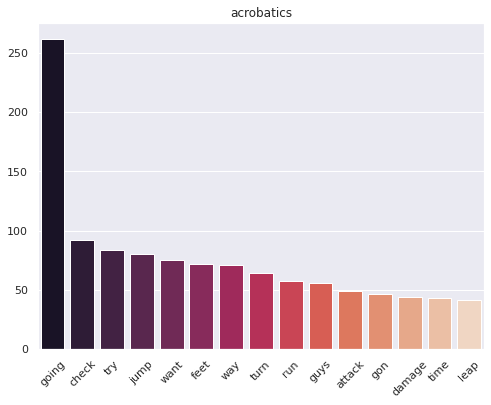

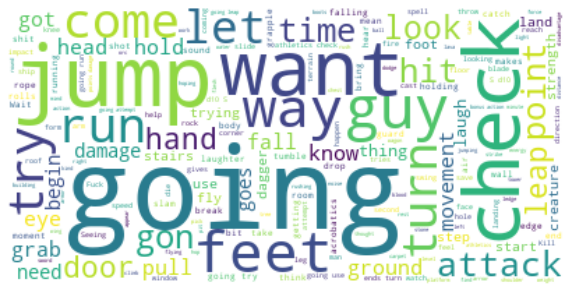

In [185]:
for skill in skill_list[:1]:
    flat_list = [item for sublist in skill_text_groupby[skill] for item in sublist]
    bar_graphic(lista_ocorrencias=flat_list, title=skill, dim=(8,6))
    wordcloud(' '.join(flat_list))